# **Import libraries**

In [1]:
from datasets import load_dataset
import vaex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.stemmer import FarasaStemmer
from farasa.segmenter import FarasaSegmenter
from tqdm import tqdm
from tqdm.notebook import tqdm
import re
from farasa.stemmer import FarasaStemmer
import qalsadi.lemmatizer
from arabicstopwords.stopwords_lexicon import stopwords_lexicon 
from camel_tools.sentiment import SentimentAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# **Import dataset**

In [2]:
dataset = load_dataset('J-Mourad/MNAD.v2')

C:\Users\khira\anaconda3\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


# **Exploratory Data Analysis**

In [3]:
# Print basic information about the loaded dataset
print(dataset)# Print basic information about the loaded dataset

DatasetDict({
    train: Dataset({
        features: ['Title', 'Body', 'Category', 'Source'],
        num_rows: 1069489
    })
})


In [4]:
# Convert the entire dataset to a Pandas DataFrame
df = pd.DataFrame(dataset['train'])

In [5]:
df.head()

,Title,Body,Category,Source
0,البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وه...,أخبارنا المغربية : سناء الوردي لازالت الحكومة ...,Business,Akhbarona.ma
1,افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 2...,أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فع...,Business,Akhbarona.ma
2,فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا با...,الحسن فاتحي استبشر مجموعة من الفاعلون السياحيو...,Business,Akhbarona.ma
3,اتفاقات ثنائية بـ150 مليون يورو بين المغرب وال...,الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي...,Business,Akhbarona.ma
4,أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من...,أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا...,Business,Akhbarona.ma


In [6]:
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (1069489, 4)


We have 1 069 489 rows and 4 columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069489 entries, 0 to 1069488
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Title     1069489 non-null  object
 1   Body      1069489 non-null  object
 2   Category  1069489 non-null  object
 3   Source    1069489 non-null  object
dtypes: object(4)
memory usage: 32.6+ MB


We have 4 columns :

**1. Title**

**2. Body**

**3. Category**

**4. Source**

In [8]:
# Check the number of unique categories
unique_categories = df['Category'].nunique()
print("Number of Unique Categories:", unique_categories)

Number of Unique Categories: 20


In [9]:
df['Category'].value_counts()

Society          310677
Sport            217914
Policy           153806
International     89122
Events            59318
Business          55465
Culture           49423
World             27526
Regions           22860
Influencers       18490
Immigrants        14899
National          13542
Environment       12766
Tech               7561
Health             7190
Women              5153
Education          1430
Tamazight          1079
Religion            844
Cars                424
Name: Category, dtype: int64

In [10]:
# Check the number of unique sources
unique_sources = df['Source'].nunique()
print("Number of Unique Sources:", unique_sources)

Number of Unique Sources: 11


In [11]:
df['Source'].value_counts()

Alyaoum24.com     156633
Hespress.ma       151798
Le360.com         144695
Barlamane.com     127127
Alayam24.com      105455
Al3omk.com        101161
Anfaspress.com     96385
Hibapress.com      64722
Akhbarona.ma       57348
Medi1News.com      48563
SnrtNews.com       15602
Name: Source, dtype: int64

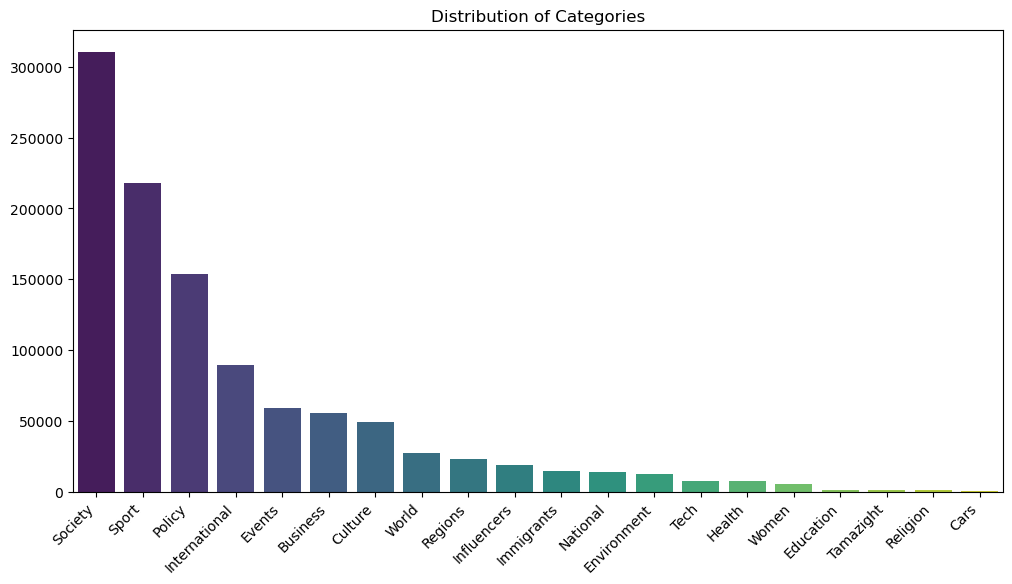

In [12]:
category_counts = df['Category'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Distribution of Categories')
plt.xticks(rotation=45, ha='right')
plt.show()

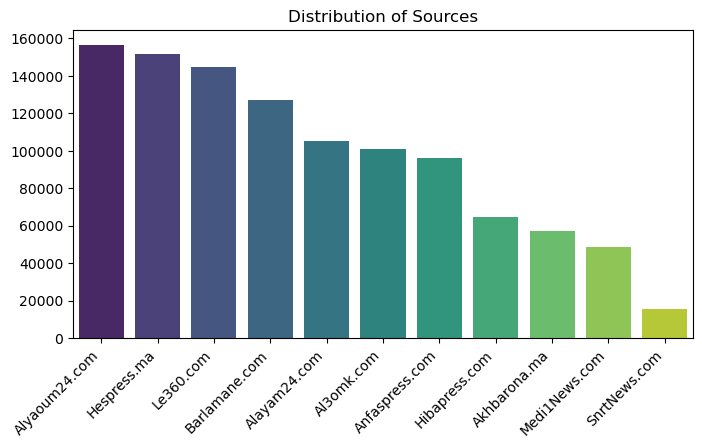

In [13]:
# Explore Source Distribution
source_counts = df['Source'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=source_counts.index, y=source_counts.values, palette="viridis")
plt.title('Distribution of Sources')
plt.xticks(rotation=45, ha='right')
plt.show()

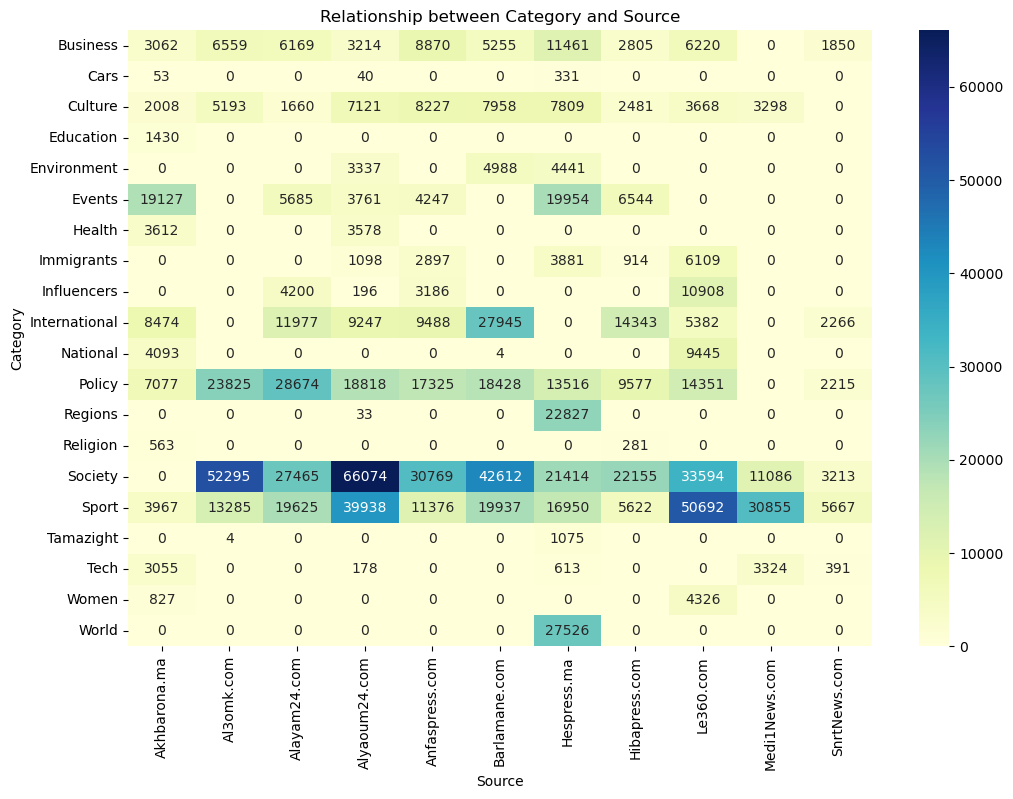

In [14]:
# Explore relationships between 'Category' and 'Source'
cross_tab = pd.crosstab(df['Category'], df['Source'])
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, cmap="YlGnBu", annot=True, fmt="d", cbar=True)
plt.title('Relationship between Category and Source')
plt.show()

# **Data Preprocessing**

In [15]:
# Initialiser 
vaex_df = vaex.from_pandas(df)

In [16]:
vaex_df.head()

#,Title,Body,Category,Source
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma
5,الملياردير ميلود الشعبي يستقيل من مجلس النواب,'أخبارنا المغربية ـ الرباط علمت أخبارنا ، أن الب...,Policy,Akhbarona.ma
6,'هذا هو عدد البرلمانيين الذين هجروا البرلمان منذ...,'نورالدين ثلاج :أخبارنا المغربية تداول مكتب مجلس...,Policy,Akhbarona.ma
7,حصاد يحدث منصب مدير للجماعة و هذه هي مهمته,'أخبارنا المغربية سحب وزير الداخلية محمد حصاد ال...,Policy,Akhbarona.ma
8,شباط يوقف شعارات ضد بنكيران احتراما للمرحوم باها,'أوقف حميد شباط صباح يوم السبت 13 دجنبر 2014 خلا...,Policy,Akhbarona.ma
9,'أنباء عن تحديد هوية المدعو كريس كولمان ، مسرب ا...,'أحمد علالي وأخيرا تم التعرف على هوية المدعو كري...,Policy,Akhbarona.ma


## Tokenization

In [17]:
def tokenize_arabic_farasa(text):
    farasa_segmenter = FarasaSegmenter(interactive=True)
    tokens = farasa_segmenter.segment(text)
    return tokens.split()

In [18]:
# Appliquer la fonction de tokenization à Title
vaex_df['titletokens'] = vaex_df['Title'].apply(tokenize_arabic_farasa)

In [19]:
# Appliquer la fonction de tokenization à Body
vaex_df['bodytokens'] = vaex_df['Body'].apply(tokenize_arabic_farasa)

In [20]:
# Afficher le résultat
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد..."
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',..."
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',..."
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل..."
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع..."


## Remove affixes

In [21]:
def process_arabic_token_list(tokens_list):
    processed_tokens = []
    for token in tokens_list:
        # Trouver les positions des signes '+'
        plus_positions = [i for i, char in enumerate(token) if char == '+']

        # Si aucun signe '+' n'est présent, ajouter le token tel quel
        if not plus_positions:
            processed_tokens.append(token)

        # Si un seul signe '+' est présent, diviser le token et ajouter la partie la plus longue
        elif len(plus_positions) == 1:
            processed_tokens.append(max(token.split('+'), key=len))

        # Si deux signes '+' sont présents
        elif len(plus_positions) == 2:
            # Diviser le token en parties entre les signes '+'
            parts = token.split('+')

            # Garder la partie entre les deux signes '+'
            processed_token = parts[plus_positions[0] + 1:plus_positions[1]]

            # Concaténer les parties pour former le token final
            processed_token = ''.join(processed_token)
            processed_tokens.append(processed_token)

    return processed_tokens


In [22]:
# Appliquer la fonction à la colonne 'titletokens' pour chaque mot individuellement
vaex_df['supptitleaffixes'] = vaex_df['titletokens'].apply(process_arabic_token_list)

In [23]:
# Appliquer la fonction à la colonne 'titletokens' pour chaque mot individuellement
vaex_df['suppbodyaffixes'] = vaex_df['bodytokens'].apply(process_arabic_token_list)

In [24]:
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens,supptitleaffixes,suppbodyaffixes
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد...","""['', 'يريد', 'توريث', 'تقاعد', 'هم', '،', 'هذا'...","""['أخبار', '', ':', 'سناء', 'وردي', 'ت', '', '',..."
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', '', 'انطلق', 'يوم', 'اثنين', 'دبي', '..."
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', '', ''..."
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ..."
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع...","""['أسعار', '', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء...","""['أخبار', '', 'كما', 'يعرف', 'سعر', 'بنزين', 'ا..."


## Remove ponctuation

In [25]:
def remove_arabic_punctuation_from_list(tokens_list):
    arabic_punctuation_pattern = r'[%():/.؀-؃؆-؏؛؞؟،]'
    tokens_without_punct = [re.sub(arabic_punctuation_pattern, '', token) for token in tokens_list]
    return [token for token in tokens_without_punct if token]  # Supprimer les chaînes vides

In [26]:
# Appliquer la fonction à la colonne
vaex_df['noponcttitle'] = vaex_df['supptitleaffixes'].apply(remove_arabic_punctuation_from_list)

In [27]:
# Appliquer la fonction à la colonne
vaex_df['noponctbody'] = vaex_df['suppbodyaffixes'].apply(remove_arabic_punctuation_from_list)

In [28]:
# Afficher le résultat
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens,supptitleaffixes,suppbodyaffixes,noponcttitle,noponctbody
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد...","""['', 'يريد', 'توريث', 'تقاعد', 'هم', '،', 'هذا'...","""['أخبار', '', ':', 'سناء', 'وردي', 'ت', '', '',...","""['يريد', 'توريث', 'تقاعد', 'هم', 'هذا', 'هو', '...","""['أخبار', 'سناء', 'وردي', 'ت', 'التي', 'يقود', ..."
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', '', 'انطلق', 'يوم', 'اثنين', 'دبي', '...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال..."
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', '', ''...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', 'تنغير..."
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ..."
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع...","""['أسعار', '', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء...","""['أخبار', '', 'كما', 'يعرف', 'سعر', 'بنزين', 'ا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'كما', 'يعرف', 'سعر', 'بنزين', 'انخفا..."


## Remove stopwords

In [29]:
def remove_arabic_stopwords(tokens_list):
    lexicon = stopwords_lexicon()
    return [token for token in tokens_list if not lexicon.is_stop(token)]

In [30]:
# Appliquer la fonction à la colonne
vaex_df['nostopwordstitle'] = vaex_df['noponcttitle'].apply(remove_arabic_stopwords)

In [31]:
vaex_df['nostopwordstitle']

Expression = nostopwordstitle
Length: 1,069,489 dtype: string (column)
----------------------------------------
      0                   ['يريد', 'توريث', 'تقاعد', 'موقف']
      1  "['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...
      2  "['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...
      3  "['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...
      4  "['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...
                            ...                             
1069484  "['ودي', 'مغرب', 'برازيل', 'بيان', 'ريشارليسون',...
1069485                                     ['فرنسا', 'حجب']
1069486  "['انهيار', 'أسهم', 'مصارف', 'كبرى', 'صفق', 'كري...
1069487  "['توقف', 'اضطراري', 'طائر', 'وداد', 'تغادر', 'ل...
1069488  "['زلزال', 'قوي', 'يخلف', '15', 'قتيل', 'إكوادور...

In [32]:
vaex_df['nostopwordsbody'] = vaex_df['noponctbody'].apply(remove_arabic_stopwords)

In [33]:
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens,supptitleaffixes,suppbodyaffixes,noponcttitle,noponctbody,nostopwordstitle,nostopwordsbody
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد...","""['', 'يريد', 'توريث', 'تقاعد', 'هم', '،', 'هذا'...","""['أخبار', '', ':', 'سناء', 'وردي', 'ت', '', '',...","""['يريد', 'توريث', 'تقاعد', 'هم', 'هذا', 'هو', '...","""['أخبار', 'سناء', 'وردي', 'ت', 'التي', 'يقود', ...","['يريد', 'توريث', 'تقاعد', 'موقف']","""['أخبار', 'سناء', 'وردي', 'يقود', 'عبد', 'إله',..."
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', '', 'انطلق', 'يوم', 'اثنين', 'دبي', '...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال..."
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', '', ''...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', 'تنغير...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي..."
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ..."
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع...","""['أسعار', '', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء...","""['أخبار', '', 'كما', 'يعرف', 'سعر', 'بنزين', 'ا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'كما', 'يعرف', 'سعر', 'بنزين', 'انخفا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'يعرف', 'سعر', 'بنزين', 'انخفاض', 'طف..."


## Stemming

In [34]:
# Function to perform stemming using FarasaStemmer
def farasa_stem_arabic(text):
    # Initialize FarasaStemmer
    stemmer = FarasaStemmer(interactive=True)
    
    # Perform stemming on each word in the title
    stemmed_text = [stemmer.stem(word) for word in text]
    
    return stemmed_text


In [35]:
vaex_df['stemmed_title'] = vaex_df['nostopwordstitle'].apply(farasa_stem_arabic)

In [36]:
vaex_df['stemmed_body'] = vaex_df['nostopwordsbody'].apply(farasa_stem_arabic)

In [37]:
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens,supptitleaffixes,suppbodyaffixes,noponcttitle,noponctbody,nostopwordstitle,nostopwordsbody,stemmed_title,stemmed_body
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد...","""['', 'يريد', 'توريث', 'تقاعد', 'هم', '،', 'هذا'...","""['أخبار', '', ':', 'سناء', 'وردي', 'ت', '', '',...","""['يريد', 'توريث', 'تقاعد', 'هم', 'هذا', 'هو', '...","""['أخبار', 'سناء', 'وردي', 'ت', 'التي', 'يقود', ...","['يريد', 'توريث', 'تقاعد', 'موقف']","""['أخبار', 'سناء', 'وردي', 'يقود', 'عبد', 'إله',...","['أراد', 'توريث', 'تقاعد', 'موقف']","""['خبر', 'سناء', 'وردي', 'قاد', 'عبد', 'إله', 'ب..."
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', '', 'انطلق', 'يوم', 'اثنين', 'دبي', '...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['خبر', 'انطلق', 'يوم', 'اثنان', 'دبي', 'فعالي'..."
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', '', ''...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', 'تنغير...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي..."
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'ال', 'وقع', 'مغرب', 'بلد', 'وحيد', 'ت..."
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع...","""['أسعار', '', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء...","""['أخبار', '', 'كما', 'يعرف', 'سعر', 'بنزين', 'ا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'كما', 'يعرف', 'سعر', 'بنزين', 'انخفا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'يعرف', 'سعر', 'بنزين', 'انخفاض', 'طف...","""['سعر', 'عرف', 'انخفاض', 'طفيف', 'ابتداء', 'يوم...","""['خبر', 'عرف', 'سعر', 'بنزين', 'انخفاض', 'طفيف'..."


## Lemmatization

In [38]:
def lemmatize_arabic_qalsadi(text):
    # Initialize the Qalsadi lemmatizer
    lemmer = qalsadi.lemmatizer.Lemmatizer()

    # Lemmatize a text and return the result
    lemmas = lemmer.lemmatize_text(text)
    
    return lemmas

In [39]:
# Apply lemmatization to the title and body tokens using Qalsadi
vaex_df['lemmatized_title'] = vaex_df['stemmed_title'].apply(lambda x: lemmatize_arabic_qalsadi(' '.join(x)))
vaex_df['lemmatized_body'] = vaex_df['stemmed_body'].apply(lambda x: lemmatize_arabic_qalsadi(' '.join(x)))

In [40]:
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens,supptitleaffixes,suppbodyaffixes,noponcttitle,noponctbody,nostopwordstitle,nostopwordsbody,stemmed_title,stemmed_body,lemmatized_title,lemmatized_body
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد...","""['', 'يريد', 'توريث', 'تقاعد', 'هم', '،', 'هذا'...","""['أخبار', '', ':', 'سناء', 'وردي', 'ت', '', '',...","""['يريد', 'توريث', 'تقاعد', 'هم', 'هذا', 'هو', '...","""['أخبار', 'سناء', 'وردي', 'ت', 'التي', 'يقود', ...","['يريد', 'توريث', 'تقاعد', 'موقف']","""['أخبار', 'سناء', 'وردي', 'يقود', 'عبد', 'إله',...","['أراد', 'توريث', 'تقاعد', 'موقف']","""['خبر', 'سناء', 'وردي', 'قاد', 'عبد', 'إله', 'ب...","['راد', 'توريث', 'تقاعد', 'موقف']","""['خبر', 'سناء', 'ردة', 'قاد', 'عبد', 'إله', 'بن..."
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', '', 'انطلق', 'يوم', 'اثنين', 'دبي', '...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['خبر', 'انطلق', 'يوم', 'اثنان', 'دبي', 'فعالي'...","""['افتتاح', 'معرض', 'أوسط', 'طير', 'خاص', 'ميبا'...","""['خبر', 'انطلق', 'يوم', 'اثنان', 'دب', 'فعال', ..."
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', '', ''...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', 'تنغير...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي...","""['فاعل', 'ون', 'سياح', 'تنغير', 'استبشر', 'خير'...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي..."
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'ال', 'وقع', 'مغرب', 'بلد', 'وحيد', 'ت...","""['اتفاق', 'ثناء', '150', 'مليون', 'يورو', 'مغرب...","""['رباط', 'ال', 'وقع', 'مغرب', 'بلد', 'حيد', 'تم..."
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع...","""['أسعار', '', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء...","""['أخبار', '', 'كما', 'يعرف', 'سعر', 'بنزين', 'ا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'كما', 'يعرف', 'سعر', 'بنزين', 'انخفا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'يعرف', 'سعر', 'بنزين', 'انخفاض', 'طف...","""['سعر', 'عرف', 'انخفاض', 'طفيف', 'ابتداء', 'يوم...","""['خبر', 'عرف', 'سعر', 'بنزين', 'انخفاض', 'طفيف'...","""['سعر', 'عرف', 'انخ

#  **Sentiment analysis**

In [41]:
# Load the pre-trained model and tokenizer
model_name = "aubmindlab/bert-base-arabertv02"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to perform sentiment analysis on the lemmatized_title column
def analyze_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [42]:
# Apply the function to create a new column 'sentiment_label'
vaex_df['sent_lab_title'] = vaex_df['lemmatized_title'].apply(analyze_sentiment)

In [43]:
vaex_df['sent_lab_body'] = vaex_df['lemmatized_body'].apply(analyze_sentiment)

In [45]:
vaex_df.head(5)

#,Title,Body,Category,Source,titletokens,bodytokens,supptitleaffixes,suppbodyaffixes,noponcttitle,noponctbody,nostopwordstitle,nostopwordsbody,stemmed_title,stemmed_body,lemmatized_title,lemmatized_body,sent_lab_title,sent_lab_body
0,'البرلمانيون يريدون توريث تقاعدهم لأبنائهم ، وهذ...,'أخبارنا المغربية : سناء الوردي لازالت الحكومة ا...,Business,Akhbarona.ma,"""['ال+برلماني+ون', 'يريد+ون', 'توريث', 'تقاعد+هم...","""['أخبار+نا', 'ال+مغربي+ة', ':', 'سناء', 'ال+ورد...","""['', 'يريد', 'توريث', 'تقاعد', 'هم', '،', 'هذا'...","""['أخبار', '', ':', 'سناء', 'وردي', 'ت', '', '',...","""['يريد', 'توريث', 'تقاعد', 'هم', 'هذا', 'هو', '...","""['أخبار', 'سناء', 'وردي', 'ت', 'التي', 'يقود', ...","['يريد', 'توريث', 'تقاعد', 'موقف']","""['أخبار', 'سناء', 'وردي', 'يقود', 'عبد', 'إله',...","['أراد', 'توريث', 'تقاعد', 'موقف']","""['خبر', 'سناء', 'وردي', 'قاد', 'عبد', 'إله', 'ب...","['راد', 'توريث', 'تقاعد', 'موقف']","""['خبر', 'سناء', 'ردة', 'قاد', 'عبد', 'إله', 'بن...",LABEL_1,LABEL_0
1,'افتتاح معرض الشرق الأوسط للطيران الخاص (ميبا 20...,'أخبارنا المغربية انطلقت اليوم الاثنين بدبي، فعا...,Business,Akhbarona.ma,"""['افتتاح', 'معرض', 'ال+شرق', 'ال+أوسط', 'ل+ال+ط...","""['أخبار+نا', 'ال+مغربي+ة', 'انطلق+ت', 'ال+يوم',...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', '', 'انطلق', 'يوم', 'اثنين', 'دبي', '...","""['افتتاح', 'معرض', 'شرق', 'أوسط', 'طيران', 'خاص...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['أخبار', 'انطلق', 'يوم', 'اثنين', 'دبي', 'فعال...","""['افتتاح', 'معرض', 'أوسط', 'طيران', 'خاص', 'ميب...","""['خبر', 'انطلق', 'يوم', 'اثنان', 'دبي', 'فعالي'...","""['افتتاح', 'معرض', 'أوسط', 'طير', 'خاص', 'ميبا'...","""['خبر', 'انطلق', 'يوم', 'اثنان', 'دب', 'فعال', ...",LABEL_1,LABEL_0
2,'فاعلون ومنعشون سياحيون بتنغير يستبشرون خيرا باف...,'الحسن فاتحي استبشر مجموعة من الفاعلون السياحيون...,Business,Akhbarona.ma,"""['فاعل+ون', 'و+منعش+ون', 'سياحي+ون', 'ب+تنغير',...","""['ال+حسن', 'فاتح+ي', 'استبشر', 'مجموع+ة', 'من',...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', '', ''...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'من', 'تنغير...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي...","""['فاعل', 'ون', 'سياحي', 'تنغير', 'يستبشرون', 'خ...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي...","""['فاعل', 'ون', 'سياح', 'تنغير', 'استبشر', 'خير'...","""['حسن', 'فاتح', 'استبشر', 'مجموع', 'تنغير', 'خي...",LABEL_0,LABEL_1
3,'اتفاقات ثنائية بـ150 مليون يورو بين المغرب والا...,'الرباط ـــ وكالات وقع المغرب البلد الوحيد الذي ...,Business,Akhbarona.ma,"""['اتفاق+ات', 'ثنائي+ة', 'ب', '150', 'مليون', 'ي...","""['ال+رباط', 'وكال+ات', 'وقع', 'ال+مغرب', 'ال+بل...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', 'ب', '150', 'مليون', 'يورو',...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'وكال', 'وقع', 'مغرب', 'بلد', 'وحيد', ...","""['اتفاق', 'ثنائي', '150', 'مليون', 'يورو', 'مغر...","""['رباط', 'ال', 'وقع', 'مغرب', 'بلد', 'وحيد', 'ت...","""['اتفاق', 'ثناء', '150', 'مليون', 'يورو', 'مغرب...","""['رباط', 'ال', 'وقع', 'مغرب', 'بلد', 'حيد', 'تم...",LABEL_1,LABEL_1
4,'أسعار المحروقات ستعرف انخفاضا طفيفا ابتداءا من ...,'أخبارنا المغربية كما سيعرف سعر البنزين انخفاضا ...,Business,Akhbarona.ma,"""['أسعار', 'ال+محروق+ات', 'س+تعرف', 'انخفاض+ا', ...","""['أخبار+نا', 'ال+مغربي+ة', 'كما', 'س+يعرف', 'سع...","""['أسعار', '', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء...","""['أخبار', '', 'كما', 'يعرف', 'سعر', 'بنزين', 'ا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'كما', 'يعرف', 'سعر', 'بنزين', 'انخفا...","""['أسعار', 'تعرف', 'انخفاض', 'طفيف', 'ابتداء', '...","""['أخبار', 'يعرف', 'سعر', 'بنزين', 'انخفاض', 'طف...","""['سعر', 'عرف', 'انخفاض', 'طفيف', 'اب

# **Subjectivity/objectivity analysis**

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import vaex

# Load AraBERT and its tokenizer
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define a custom dataset class
class SubjectivityDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'label': torch.tensor(label)}

# Assuming 'lemmatized_title' and 'subjectivity_label' columns in vaex_df
texts = vaex_df['lemmatized_title'].to_numpy()
labels = vaex_df['subjectivity_label'].to_numpy()

dataset = SubjectivityDataset(texts, labels)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}"):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

# Save the fine-tuned model
model.save_pretrained("fine_tuned_arabert_subjectivity")
tokenizer.save_pretrained("fine_tuned_arabert_subjectivity")


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer